# ADS 509 Assignment 5.1: Topic Modeling

This notebook holds Assignment 5.1 for Module 5 in ADS 509, Applied Text Mining. Work through this notebook, writing code and answering questions where required. 

In this assignment you will work with a categorical corpus that accompanies `nltk`. You will build the three types of topic models described in Chapter 8 of _Blueprints for Text Analytics using Python_: NMF, LSA, and LDA. You will compare these models to the true categories. 


In [1]:
# These libraries may be useful to you
import nltk
nltk.download('brown')
from nltk.corpus import brown

import numpy as np
import pandas as pd
from tqdm.auto import tqdm

#conda install -c conda-forge pyldavis
import pyLDAvis
import pyLDAvis.lda_model
import pyLDAvis.gensim_models

#conda install -c conda-forge spacy
import spacy
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.decomposition import NMF, TruncatedSVD, LatentDirichletAllocation

from spacy.lang.en.stop_words import STOP_WORDS as stopwords

from collections import Counter, defaultdict

import spacy.cli
#spacy.cli.download("en_core_web_sm")
import en_core_web_sm


nlp = en_core_web_sm.load()

[nltk_data] Downloading package brown to
[nltk_data]     /Users/clairebentzen/nltk_data...
[nltk_data]   Package brown is already up-to-date!


In [2]:
# add any additional libraries you need here
import matplotlib.pyplot as plt



In [3]:
# This function comes from the BTAP repo.

def display_topics(model, features, no_top_words=5):
    for topic, words in enumerate(model.components_):
        total = words.sum()
        largest = words.argsort()[::-1] # invert sort order
        print("\nTopic %02d" % topic)
        for i in range(0, no_top_words):
            print("  %s (%2.2f)" % (features[largest[i]], abs(words[largest[i]]*100.0/total)))

## Getting to Know the Brown Corpus

Let's spend a bit of time getting to know what's in the Brown corpus, our NLTK example of an "overlapping" corpus.

In [4]:
# categories of articles in Brown corpus
for category in brown.categories() :
    print(f"For {category} we have {len(brown.fileids(categories=category))} articles.")

For adventure we have 29 articles.
For belles_lettres we have 75 articles.
For editorial we have 27 articles.
For fiction we have 29 articles.
For government we have 30 articles.
For hobbies we have 36 articles.
For humor we have 9 articles.
For learned we have 80 articles.
For lore we have 48 articles.
For mystery we have 24 articles.
For news we have 44 articles.
For religion we have 17 articles.
For reviews we have 17 articles.
For romance we have 29 articles.
For science_fiction we have 6 articles.


Let's create a dataframe of the articles in of hobbies, editorial, government, news, and romance.

In [5]:
categories = ['editorial','government','news','romance','hobbies'] 

category_list = []
file_ids = []
texts = []

for category in categories : 
    for file_id in brown.fileids(categories=category) :
        
        # build some lists for a dataframe
        category_list.append(category)
        file_ids.append(file_id)
        
        text = brown.words(fileids=file_id)
        texts.append(" ".join(text))

        
        
df = pd.DataFrame()
df['category'] = category_list
df['id'] = file_ids
df['text'] = texts 

df.shape

(166, 3)

In [6]:
# Let's add some helpful columns on the df
df['char_len'] = df['text'].apply(len)
df['word_len'] = df['text'].apply(lambda x: len(x.split()))

<Axes: xlabel='category'>

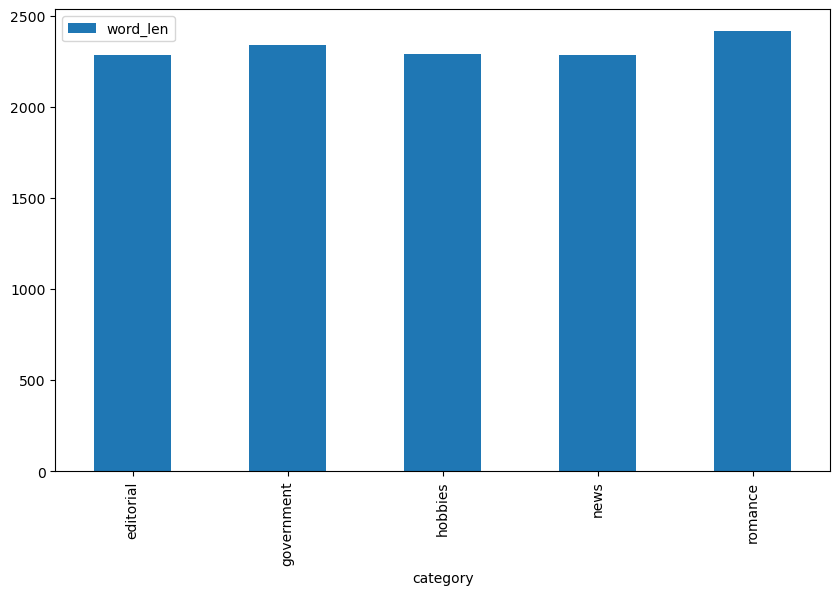

In [7]:
%matplotlib inline
df.groupby('category').agg({'word_len': 'mean'}).plot.bar(figsize=(10,6))

Now do our TF-IDF and Count vectorizations.

In [8]:
count_text_vectorizer = CountVectorizer(stop_words=list(stopwords), min_df=5, max_df=0.7)
count_text_vectors = count_text_vectorizer.fit_transform(df["text"])
count_text_vectors.shape

/Users/clairebentzen/anaconda3/lib/python3.11/site-packages/sklearn/feature_extraction/text.py:408: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['ll', 've'] not in stop_words.
  warnings.warn(


(166, 4941)

In [9]:
tfidf_text_vectorizer = TfidfVectorizer(stop_words=list(stopwords), min_df=5, max_df=0.7)
tfidf_text_vectors = tfidf_text_vectorizer.fit_transform(df['text'])
tfidf_text_vectors.shape

(166, 4941)

Q: What do the two data frames `count_text_vectors` and `tfidf_text_vectors` hold? 

A: The count_text_vectors is a sparse matrix that holds the token frequency counts of the text, with the columns being the tokens and the rows referring to the texts. The tfidf_text_vectors holds a sparse matrix that is similar to count_text_vectors, except the token frequency counts are scaled by the TF-IDF weights. For both dataframes, stopwords are removed, it only includes tokens that are in a minimum of 5 texts, and tokens that are present in 70% or more of the texts are not included.

## Fitting a Non-Negative Matrix Factorization Model

In this section the code to fit a five-topic NMF model has already been written. This code comes directly from the [BTAP repo](https://github.com/blueprints-for-text-analytics-python/blueprints-text), which will help you tremendously in the coming sections. 

In [10]:
nmf_text_model = NMF(n_components=5, random_state=314)
W_text_matrix = nmf_text_model.fit_transform(tfidf_text_vectors)
H_text_matrix = nmf_text_model.components_

In [11]:
display_topics(nmf_text_model, tfidf_text_vectorizer.get_feature_names_out())


Topic 00
  mr (0.51)
  president (0.45)
  kennedy (0.43)
  united (0.42)
  khrushchev (0.40)

Topic 01
  said (0.88)
  didn (0.46)
  ll (0.45)
  thought (0.42)
  man (0.37)

Topic 02
  state (0.39)
  development (0.36)
  tax (0.33)
  sales (0.30)
  program (0.25)

Topic 03
  mrs (2.61)
  mr (0.78)
  said (0.63)
  miss (0.52)
  car (0.51)

Topic 04
  game (1.02)
  league (0.74)
  ball (0.72)
  baseball (0.71)
  team (0.66)


Now some work for you to do. Compare the NMF categorization to the original categories from the Brown Corpus.

We are interested in the extent to which our NMF categorization agrees or disagrees with the original categories in the corpus. For each topic in your NMF model, tally the Brown categories and interpret the results. 


In [30]:
# Get topic from W matrix for each text
df['nmf_cat'] = W_text_matrix.argmax(axis=1)

# Count categories by each NMF assigned topic
nmf_comparison = df.groupby(['nmf_cat', 'category']).size().reset_index(name='count')
nmf_comparison_sort = nmf_comparison.sort_values(by=['nmf_cat', 'count'], ascending=[True, False])
nmf_comparison_sort

,nmf_cat,category,count
0,0,editorial,20
2,0,news,8
1,0,government,4
5,1,romance,29
4,1,hobbies,8
3,1,editorial,4
7,2,government,26
8,2,hobbies,26
9,2,news,11
6,2,editorial,2


Q: How does your five-topic NMF model compare to the original Brown categories? 

A: Topic 0, which includes mr, president, kennedy, united, and khrushchev, as the top tokens, was assigned to the texts in the following categories: editorial (20 times), news (8 times), and government (4 times). Topic 1, which includes said, didn, ll, thought, and man, as the top tokens, was assigned to the texts in the following categories: romance (29 times), hobbies (8 times), and editorial (4 times). Topic 2, which includes state, development, tax, sales, and program, as the top tokens, was assigned to the texts in the following categories: government (26 times), hobbies (26 times), news (11 times), and editorial (2 times). Topic 3, which includes mrs, mr, said, miss, and car, as the top tokens, was assigned to the texts in the following categories: news (17 times) and hobbies (1 time). Topic 4, which includes game, league, ball, baseball, and team, as the top tokens, was assigned to the texts in the following categories: news (8 times), editorial (1 time), and hobbies (1 time). In general, I would say these topics don't do a very good job at identifying the original categories.

## Fitting an LSA Model

In this section, follow the example from the repository and fit an LSA model (called a "TruncatedSVD" in `sklearn`). Again fit a five-topic model and compare it to the actual categories in the Brown corpus. Use the TF-IDF vectors for your fit, as above. 

To be explicit, we are once again interested in the extent to which this LSA factorization agrees or disagrees with the original categories in the corpus. For each topic in your model, tally the Brown categories and interpret the results. 


In [12]:
# Fit an LSA (TruncatedSVD) model
lsa_text_model = TruncatedSVD(n_components=5, random_state=314)
W_lsa_matrix = lsa_text_model.fit_transform(tfidf_text_vectors)
H_lsa_matrix = lsa_text_model.components_

In [14]:
# Display Topics
display_topics(lsa_text_model, tfidf_text_vectorizer.get_feature_names_out())


Topic 00
  said (0.44)
  mr (0.25)
  mrs (0.22)
  state (0.20)
  man (0.17)

Topic 01
  said (3.89)
  ll (2.73)
  didn (2.63)
  thought (2.20)
  got (1.97)

Topic 02
  mrs (3.12)
  mr (1.70)
  said (1.06)
  kennedy (0.82)
  khrushchev (0.77)

Topic 03
  mrs (29.45)
  club (6.53)
  game (6.12)
  jr (5.60)
  university (5.20)

Topic 04
  game (4.54)
  league (3.27)
  baseball (3.22)
  ball (3.10)
  team (2.94)


Q: What is your interpretation of the display topics output? 

A: 

In [13]:
# Get topic from W matrix for each text
df['lsa_cat'] = W_lsa_matrix.argmax(axis=1)

# Count categories by each LSA assigned topic
lsa_comparison = df.groupby(['lsa_cat', 'category']).size().reset_index(name='count')
lsa_comparison_sort = lsa_comparison.sort_values(by=['lsa_cat', 'count'], ascending=[True, False])
lsa_comparison_sort

,lsa_cat,category,count
2,0,hobbies,36
3,0,news,34
1,0,government,30
0,0,editorial,27
4,0,romance,21
5,1,romance,8
6,3,news,3
7,4,news,7


Q: How does your five-topic LSA model compare to the original Brown categories? 

A: <!-- Your answer here --> 

## Fitting an LDA Model

Finally, fit a five-topic LDA model using the count vectors (`count_text_vectors` from above). Display the results using `pyLDAvis.display` and describe what you learn from that visualization. 

In [15]:
# Fit an LDA model
lda_text_model = LatentDirichletAllocation(n_components=5, random_state=314)
W_lda_matrix = lda_text_model.fit_transform(count_text_vectors)
H_lda_matrix = lda_text_model.components_

In [16]:
# Display topics
display_topics(lda_text_model, count_text_vectorizer.get_feature_names_out())


Topic 00
  said (1.05)
  mrs (0.82)
  little (0.56)
  good (0.51)
  way (0.50)

Topic 01
  state (0.67)
  development (0.63)
  000 (0.57)
  program (0.48)
  business (0.44)

Topic 02
  said (1.18)
  mr (0.72)
  president (0.51)
  city (0.43)
  state (0.37)

Topic 03
  feed (0.55)
  college (0.54)
  general (0.44)
  university (0.43)
  work (0.37)

Topic 04
  states (1.14)
  state (1.02)
  united (0.84)
  shall (0.66)
  government (0.61)


Q: What inference do you draw from the displayed topics for your LDA model? 

A: <!-- Your answer here --> 

In [17]:
# Get topic from W matrix for each text
df['lda_cat'] = W_lda_matrix.argmax(axis=1)

# Count categories by each LDA assigned topic
lda_comparison = df.groupby(['lda_cat', 'category']).size().reset_index(name='count')
lda_comparison_sort = lda_comparison.sort_values(by=['lda_cat', 'count'], ascending=[True, False])
lda_comparison_sort

,lda_cat,category,count
4,0,romance,28
2,0,hobbies,11
3,0,news,4
0,0,editorial,3
1,0,government,1
6,1,government,12
7,1,hobbies,9
8,1,news,3
5,1,editorial,1
12,2,news,32


Q: Repeat the tallying of Brown categories within your topics. How does your five-topic LDA model compare to the original Brown categories? 

A: <!-- Your answer here --> 

In [18]:
lda_display = pyLDAvis.lda_model.prepare(lda_text_model, count_text_vectors, count_text_vectorizer, sort_topics=False)

In [19]:
pyLDAvis.display(lda_display)

Q: What conclusions do you draw from the visualization above? Please address the principal component scatterplot and the salient terms graph.

A: <!-- Your answer here --> 
